In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


start time: 2021-06-15 02:15:36.584828
fff /root/.local/share/jupyter/runtime/kernel-c8566476-6b45-4afb-9973-445ef9dee6a2.json
dataset mnist
data_dir ./data
epochs 30
batch_size 32
lr 0.001
lr_decay_step [20, 25]
wdecay 0.0001
dropout 0
filters [64, 64, 64]
filter_scale 1
n_hidden 0
aggregation mean
readout max
kl_weight 100
pool None
pool_arch None
init normal
scale 1.0
degree_feature False
n_nodes 25
cv_folds 5
cv_threads 5
tune_init False
ax False
ax_trials 30
cv False
seed_data 111
img_features ['mean', 'coord']
img_noise_levels None
validation True
debug False
eval_attn_train False
eval_attn_test False
test_batch_size 100
alpha_ws None
log_interval 400
results ./results
resume None
device cuda
seed 111
threads 0
torch 1.8.1+cu101
experiment_ID:  584828
gpus:  1
torch.Size([5000, 28, 28])
ChebyGINLayer torch.Size([64, 3]) tensor([0.5949, 0.3381, 0.6084, 0.4518, 0.3925, 0.7288, 0.2208, 0.5927, 0.5338,
        0.5864], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 64]) tenso

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


features shape loaded (25138176, 3)
mn [[0.13128309 0.48098576 0.47664618]]
std [[0.2918783  0.28410038 0.28585434]]
corrected (non zeros) std [[0.2918783  0.28410038 0.28585434]]
model is checked for nodes shuffling


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train set (epoch 1): [12832/55000 (23%)]	Loss: 2.0662 (avg: 2.0967), other losses: []	Acc metric: 3024/12832 (23.57%)	 AttnAUC: []	 avg sec/iter: 0.0453
Train set (epoch 1): [25632/55000 (47%)]	Loss: 1.5926 (avg: 1.9929), other losses: []	Acc metric: 7176/25632 (28.00%)	 AttnAUC: []	 avg sec/iter: 0.0459
Train set (epoch 1): [38432/55000 (70%)]	Loss: 1.6499 (avg: 1.8939), other losses: []	Acc metric: 12402/38432 (32.27%)	 AttnAUC: []	 avg sec/iter: 0.0465
Train set (epoch 1): [51232/55000 (93%)]	Loss: 1.3373 (avg: 1.7957), other losses: []	Acc metric: 18534/51232 (36.18%)	 AttnAUC: []	 avg sec/iter: 0.0471
Train set (epoch 1): [55000/55000 (100%)]	Loss: 1.1326 (avg: 1.7691), other losses: []	Acc metric: 20509/55000 (37.29%)	 AttnAUC: []	 avg sec/iter: 0.0473
saving the model to ./results/checkpoint_mnist_584828_epoch1_seed0000111.pth.tar
model is checked for nodes shuffling
lbl: 0, avg acc: 53.78% (270/502)
lbl: 1, avg acc: 96.25% (514/534)
lbl: 2, avg acc: 49.50% (246/497)
lbl: 3, avg

/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:809: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self.file_stream.write(hdr.tostring())


pca time 0.2940938472747803
silhouette average -0.12479424 std 0.28393444
davies bouldin score 9.209021800921054
calinski harabasz score 2487.1876817907214


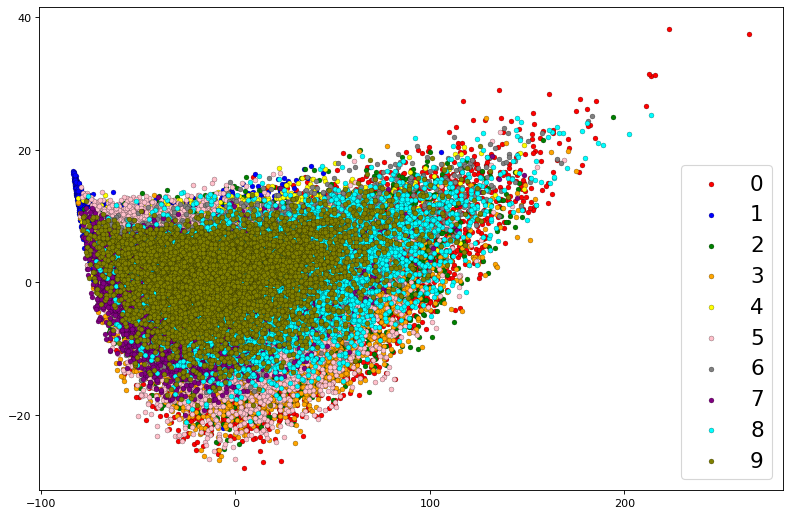

running tsne
tsne time 746.6220827102661
silhouette average -0.085532464 std 0.21178988
davies bouldin score 30.30561846589872
calinski harabasz score 1282.0210967846765


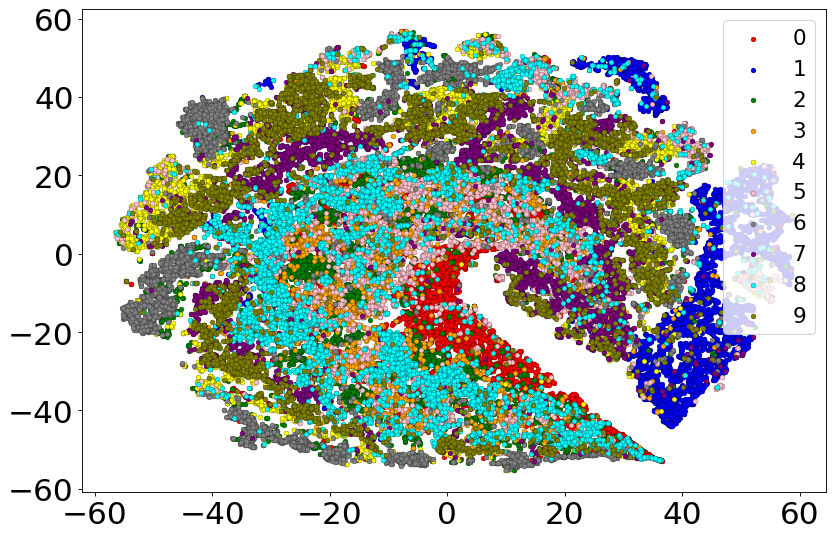

running umap


In [ ]:
!pip install umap-learn
!pip install ivis[cpu]
import sys
sys.path.append('/content/drive/MyDrive/Thesis/graph_attention_pool')
import argparse
import random
import datetime
from torchvision import transforms
from graphdata import *
from train_test import *
import warnings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.io import savemat
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pickle
from skimage.segmentation import slic
import scipy.ndimage
import scipy.spatial
import torch
from torchvision import datasets
import sys
from chebygin import ChebyGIN
from extract_superpixels import process_image
from graphdata import compute_adjacency_matrix_images
from train_test import load_save_noise
from utils import list_to_torch, data_to_device, normalize_zero_one
from scipy.stats import zscore
import time
import umap
from ivis import Ivis

warnings.filterwarnings("once")

def parse_args():
    parser = argparse.ArgumentParser(description='Run experiments with Graph Neural Networks')
    parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
    # Dataset
    parser.add_argument('-D', '--dataset', type=str, default='mnist',
                        choices=['colors-3', 'colors-4', 'colors-8', 'colors-16', 'colors-32',
                                 'triangles', 'mnist', 'mnist-75sp', 'TU'],
                        help='colors-n means the colors dataset with n-dimensional features; TU is any dataset from https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets')
    parser.add_argument('-d', '--data_dir', type=str, default='./data', help='path to the dataset')
    # Hyperparameters
    parser.add_argument('--epochs', type=int, default=None, help='# of the epochs')
    parser.add_argument('--batch_size', type=int, default=32, help='batch size for training data')
    parser.add_argument('--lr', type=float, default=0.001, help='Learning Rate')
    parser.add_argument('--lr_decay_step', type=str, default=None, help='number of epochs after which to reduce learning rate')
    parser.add_argument('--wdecay', type=float, default=1e-4, help='weight decay')
    parser.add_argument('--dropout', type=float, default=0, help='dropout rate')
    parser.add_argument('--filters', type=str, default='64,64,64', help='number of filters in each graph layer')
    parser.add_argument('--filter_scale', type=int, default=1, help='filter scale (receptive field size), must be > 0; 1 for GCN or GIN')
    parser.add_argument('--n_hidden', type=int, default=0, help='number of hidden units inside the graph layer')
    parser.add_argument('--aggregation', type=str, default='mean', choices=['mean', 'sum'], help='neighbors aggregation inside the graph layer')
    parser.add_argument('--readout', type=str, default=None, choices=['mean', 'sum', 'max'], help='type of global pooling over all nodes')
    parser.add_argument('--kl_weight', type=float, default=100, help='weight of the KL term in the loss')
    parser.add_argument('--pool', type=str, default=None, help='type of pooling between layers, None for global pooling only')
    parser.add_argument('--pool_arch', type=str, default=None, help='pooling layers architecture defining whether to use fully-connected layers or GNN and to which layer to attach (e.g.: fc_prev, gnn_prev, fc_curr, gnn_curr, fc_prev_32)')
    parser.add_argument('--init', type=str, default='normal', choices=['normal', 'uniform'], help='distribution used for initialization for the attention model')
    parser.add_argument('--scale', type=str, default='1', help='initialized weights scale for the attention model, set to None to use PyTorch default init')
    parser.add_argument('--degree_feature', action='store_true', default=False, help='use degree features (only for the Triangles dataset)')
    # TU datasets arguments
    parser.add_argument('--n_nodes', type=int, default=25, help='maximum number of nodes in the training set for collab, proteins and dd (35 for collab, 25 for proteins, 200 or 300 for dd)')
    parser.add_argument('--cv_folds', type=int, default=5, help='number of folds for cross-validating hyperparameters for collab, proteins and dd (5 or 10 shows similar results, 5 is faster)')
    parser.add_argument('--cv_threads', type=int, default=5, help='number of parallel threads for cross-validation')
    parser.add_argument('--tune_init', action='store_true', default=False, help='do not tune initialization hyperparameters')
    parser.add_argument('--ax', action='store_true', default=False, help='use AX for hyperparameter optimization (recommended)')
    parser.add_argument('--ax_trials', type=int, default=30, help='number of AX trials (hyperparameters optimization steps)')
    parser.add_argument('--cv', action='store_true', default=False, help='run in the cross-validation mode')
    parser.add_argument('--seed_data', type=int, default=111, help='random seed for data splits')
    # Image datasets arguments
    parser.add_argument('--img_features', type=str, default='mean,coord', help='image features to use as node features')
    parser.add_argument('--img_noise_levels', type=str, default=None,
                        help='Gaussian noise standard deviations for grayscale and color image features')
    # Auxiliary arguments
    parser.add_argument('--validation', action='store_true', default=True, help='run in the validation mode')
    parser.add_argument('--debug', action='store_true', default=False, help='evaluate on the test set after each epoch (only for visualization purposes)')
    parser.add_argument('--eval_attn_train', action='store_true', default=False, help='evaluate attention and save coefficients on the training set for models without learnable attention')
    parser.add_argument('--eval_attn_test', action='store_true', default=False, help='evaluate attention and save coefficients on the test set for models without learnable attention')
    parser.add_argument('--test_batch_size', type=int, default=100, help='batch size for test data')
    parser.add_argument('--alpha_ws', type=str, default=None, help='attention labels that will be used for (weak)supervision')
    parser.add_argument('--log_interval', type=int, default=400, help='print interval')
    parser.add_argument('--results', type=str, default='./results', help='directory to save model checkpoints and other results, set to None to prevent saving anything')
    parser.add_argument('--resume', type=str, default=None, help='checkpoint to load the model and optimzer states from and continue training')
    parser.add_argument('--device', type=str, default='cuda', choices=['cuda', 'cpu'], help='cuda/cpu')
    parser.add_argument('--seed', type=int, default=111, help='random seed for model parameters')
    parser.add_argument('--threads', type=int, default=0, help='number of threads for data loader')
    args = parser.parse_args()

    # Set default number of epochs and learning rate schedules and other hyperparameters
    if args.readout in [None, 'None']:
        args.readout = 'max'  # global max pooling for all datasets except for COLORS
    set_default_lr_decay_step = args.lr_decay_step in [None, 'None']
    if args.epochs in [None, 'None']:
        if args.dataset.find('mnist') >= 0:
            args.epochs = 30
            if set_default_lr_decay_step:
                args.lr_decay_step = '20,25'
        elif args.dataset == 'triangles':
            args.epochs = 100
            if set_default_lr_decay_step:
                args.lr_decay_step = '85,95'
        elif args.dataset == 'TU':
            args.epochs = 50
            if set_default_lr_decay_step:
                args.lr_decay_step = '25,35,45'
        elif args.dataset.find('color') >= 0:
            if args.readout in [None, 'None']:
                args.readout = 'sum'
            if args.pool in [None, 'None']:
                args.epochs = 100
                if set_default_lr_decay_step:
                    args.lr_decay_step = '90'
            else:
                args.epochs = 300
                if set_default_lr_decay_step:
                    args.lr_decay_step = '280'
        else:
            raise NotImplementedError(args.dataset)

    args.lr_decay_step = list(map(int, args.lr_decay_step.split(',')))
    args.filters = list(map(int, args.filters.split(',')))
    args.img_features = args.img_features.split(',')
    args.img_noise_levels = None if args.img_noise_levels in [None, 'None'] else list(map(float, args.img_noise_levels.split(',')))
    args.pool = None if args.pool in [None, 'None'] else args.pool.split('_')
    args.pool_arch = None if args.pool_arch in [None, 'None'] else args.pool_arch.split('_')
    try:
        args.scale = float(args.scale)
    except:
        args.scale = None

    args.torch = torch.__version__

    for arg in vars(args):
        print(arg, getattr(args, arg))

    return args


def load_synthetic(args):
    train_dataset = SyntheticGraphs(args.data_dir, args.dataset, 'train', degree_feature=args.degree_feature,
                                    attn_coef=args.alpha_ws)
    test_dataset = SyntheticGraphs(args.data_dir, args.dataset, 'val' if args.validation else 'test',
                                   degree_feature=args.degree_feature)
    loss_fn = mse_loss
    collate_fn = collate_batch
    in_features = train_dataset.feature_dim
    out_features = 1
    return train_dataset, test_dataset, loss_fn, collate_fn, in_features, out_features


def load_mnist(args):
    use_mean_px = 'mean' in args.img_features
    use_coord = 'coord' in args.img_features
    assert use_mean_px, ('this mode is not well supported', use_mean_px)
    gt_attn_threshold = 0 if (args.pool is not None and args.pool[1] in ['gt'] and args.filter_scale > 1) else 0.5
    if args.dataset == 'mnist':
        train_dataset = MNIST(args.data_dir, train=True, download=True, transform=transforms.ToTensor(),
                              attn_coef=args.alpha_ws)
    else:
        train_dataset = MNIST75sp(args.data_dir, split='train', use_mean_px=use_mean_px, use_coord=use_coord,
                                  gt_attn_threshold=gt_attn_threshold, attn_coef=args.alpha_ws)

    noises, color_noises = None, None
    if args.validation:
        n_val = 5000
        if args.dataset == 'mnist':
            train_dataset.data = train_dataset.train_data[:-n_val]
            train_dataset.targets = train_dataset.train_labels[:-n_val]
            test_dataset = MNIST(args.data_dir, train=True, download=True, transform=transforms.ToTensor())
            test_dataset.data = train_dataset.train_data[-n_val:]
            test_dataset.targets = train_dataset.train_labels[-n_val:]
        else:
            train_dataset.train_val_split(np.arange(0, train_dataset.n_samples - n_val))
            test_dataset = MNIST75sp(args.data_dir, split='train', use_mean_px=use_mean_px, use_coord=use_coord,
                                     gt_attn_threshold=gt_attn_threshold)
            test_dataset.train_val_split(np.arange(train_dataset.n_samples - n_val, train_dataset.n_samples))
    else:
        noise_file = pjoin(args.data_dir, '%s_noise.pt' % args.dataset.replace('-', '_'))
        color_noise_file = pjoin(args.data_dir, '%s_color_noise.pt' % args.dataset.replace('-', '_'))
        if args.dataset == 'mnist':
            test_dataset = MNIST(args.data_dir, train=False, download=True, transform=transforms.ToTensor())
            noise_shape = (len(test_dataset.test_labels), 28 * 28)
        else:
            test_dataset = MNIST75sp(args.data_dir, split='test', use_mean_px=use_mean_px, use_coord=use_coord,
                                     gt_attn_threshold=gt_attn_threshold)
            noise_shape = (len(test_dataset.labels), 75)

        # Generate/load noise (save it to make reproducible)
        noises = load_save_noise(noise_file, noise_shape)
        color_noises = load_save_noise(color_noise_file, (noise_shape[0], noise_shape[1], 3))

    if args.dataset == 'mnist':
        A, coord, mask = precompute_graph_images(train_dataset.train_data.shape[1])
        collate_fn = lambda batch: collate_batch_images(batch, A, mask, use_mean_px=use_mean_px,
                                                        coord=coord if use_coord else None,
                                                        gt_attn_threshold=gt_attn_threshold,
                                                        replicate_features=args.img_noise_levels is not None)
    else:
        train_dataset.precompute_graph_data(replicate_features=args.img_noise_levels is not None, threads=12)
        test_dataset.precompute_graph_data(replicate_features=args.img_noise_levels is not None, threads=12)
        collate_fn = collate_batch

    loss_fn = F.cross_entropy

    in_features = 0 if args.img_noise_levels is None else 2
    for features in args.img_features:
        if features == 'mean':
            in_features += 1
        elif features == 'coord':
            in_features += 2
        else:
            raise NotImplementedError(features)
    in_features = np.max((in_features, 1))  # in_features=1 if neither mean nor coord are used  (dummy features will be used in this case)
    out_features = 10

    print(test_dataset.data.shape)

    return train_dataset, test_dataset, loss_fn, collate_fn, in_features, out_features, noises, color_noises


def load_TU(args, cv_folds=5):
    loss_fn = F.cross_entropy
    collate_fn = collate_batch
    scale, init = args.scale, args.init
    n_hidden_attn = float(args.pool_arch[2]) if (args.pool_arch is not None and len(args.pool_arch) > 2) else 0
    if args.pool is None:
        # Global pooling models
        datareader = DataReader(data_dir=args.data_dir, N_nodes=args.n_nodes, rnd_state=rnd_data, folds=0)
        train_dataset = GraphData(datareader, None, 'train_val')
        test_dataset = GraphData(datareader, None, 'test')
        in_features = train_dataset.num_features
        out_features = train_dataset.num_classes
        pool = args.pool
        kl_weight = args.kl_weight
    elif args.pool[1] == 'gt':
        raise ValueError('ground truth attention for TU datasets is not available')
    elif args.pool[1] in ['sup', 'unsup']:
        datareader = DataReader(data_dir=args.data_dir, N_nodes=args.n_nodes, rnd_state=rnd_data, folds=cv_folds)
        if args.ax:
            # Cross-validation using Ax (recommended way), Python3 must be used
            best_parameters = ax_optimize(datareader, args, collate_fn, loss_fn, None, folds=cv_folds,
                                          threads=args.cv_threads, n_trials=args.ax_trials)
            pool = args.pool
            kl_weight = best_parameters['kl_weight']
            if args.tune_init:
                scale, init = best_parameters['scale'], best_parameters['init']
            n_hidden_attn, layer = best_parameters['n_hidden_attn'], 1
            if layer == 0:
                pool = copy.deepcopy(args.pool)
                del pool[3]

            pool = set_pool(best_parameters['pool'], pool)

        else:
            if not args.cv:
                # Run with some fixed parameters without cross-validation
                pool_thresh_values = np.array([float(args.pool[-1])])
                n_hiddens = [n_hidden_attn]
                layers = [1]
            elif args.debug:
                pool_thresh_values = np.array([1e-4, 1e-1])
                n_hiddens = [n_hidden_attn]
                layers = [1]
            else:
                # Cross-validation using grid search (not recommended, since it's time consuming and not effective
                if args.data_dir.lower().find('proteins') >= 0:
                    pool_thresh_values = np.array([2e-3, 5e-3, 1e-2, 3e-2, 5e-2])
                elif args.data_dir.lower().find('dd') >= 0:
                    pool_thresh_values = np.array([1e-4, 1e-3, 2e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1])
                elif args.data_dir.lower().find('collab') >= 0:
                    pool_thresh_values = np.array([1e-3, 2e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1])
                else:
                    raise NotImplementedError('this dataset is not supported currently')
                n_hiddens = np.array([0, 32])  # hidden units in the atention model
                layers = np.array([0, 1])  # layer where to attach the attention model

            if args.pool[1] == 'sup' and not args.debug and args.cv:
                kl_weight_values = np.array([0.25, 1, 2, 10])
            else:
                kl_weight_values = np.array([args.kl_weight])  # any value (ignored for unsupervised training)


            if len(pool_thresh_values) > 1 or len(kl_weight_values) > 1 or len(n_hiddens) > 1 or len(layers) > 1:
                val_acc = np.zeros((len(layers), len(n_hiddens), len(pool_thresh_values), len(kl_weight_values)))
                for i_, layer in enumerate(layers):
                    if layer == 0:
                        pool = copy.deepcopy(args.pool)
                        del pool[3]
                    else:
                        pool = args.pool
                    for j_, n_hidden_attn in enumerate(n_hiddens):
                        for k_, pool_thresh in enumerate(pool_thresh_values):
                            for m_, kl_weight in enumerate(kl_weight_values):
                                val_acc[i_, j_, k_, m_] = \
                                    cross_validation(datareader, args, collate_fn, loss_fn, set_pool(pool_thresh, pool),
                                                     kl_weight, None, n_hidden_attn=n_hidden_attn, folds=cv_folds, threads=args.cv_threads)
                ind1, ind2, ind3, ind4 = np.where(val_acc == np.max(val_acc))  # np.argmax returns only first occurrence
                print(val_acc)
                print(ind1, ind2, ind3, ind4, layers[ind1], n_hiddens[ind2], pool_thresh_values[ind3], kl_weight_values[ind4],
                      val_acc[ind1[0], ind2[0], ind3[0], ind4[0]])

                layer = layers[ind1[0]]
                if layer == 0:
                    pool = copy.deepcopy(args.pool)
                    del pool[3]
                else:
                    pool = args.pool
                n_hidden_attn = n_hiddens[ind2[0]]
                pool = set_pool(pool_thresh_values[ind3[0]], pool)
                kl_weight = kl_weight_values[ind4[0]]
            else:
                pool = args.pool
                kl_weight = args.kl_weight

        train_dataset = GraphData(datareader, None, 'train_val')
        test_dataset = GraphData(datareader, None, 'test')
        in_features = train_dataset.num_features
        out_features = train_dataset.num_classes

        if args.pool[1] == 'sup':
            # Train a model with global pooling first
            train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.threads,
                                      collate_fn=collate_fn)
            train_loader_test = DataLoader(train_dataset, batch_size=args.test_batch_size, shuffle=False,
                                           num_workers=args.threads, collate_fn=collate_fn)
            # Train global pooling model
            start_epoch, model, optimizer, scheduler = create_model_optimizer(in_features, out_features, None, kl_weight,
                                                                              args, scale=scale, init=init, n_hidden_attn=n_hidden_attn)
            for epoch in range(start_epoch, args.epochs + 1):
                scheduler.step()
                train_loss, acc = train(model, train_loader, optimizer, epoch, args, loss_fn, None)
            train_loss, train_acc, attn_WS = test(model, train_loader_test, epoch, loss_fn, 'train', args, None,
                                                  eval_attn=True)[:3]
            train_dataset = GraphData(datareader, None, 'train_val', attn_labels=attn_WS)
    else:
        raise NotImplementedError(args.pool)

    return train_dataset, test_dataset, loss_fn, collate_fn, in_features, out_features, pool, kl_weight, scale, init, n_hidden_attn


if __name__ == '__main__':
    !dataset="mnist"
    !seed=3026
    !checkpoints_dir=./checkpoints/
    !params="-D $dataset --epochs 10 --lr_decay_step 20,25 --test_batch_size 100 -K 4 -f 4,64,512 --aggregation mean --n_hidden 0 --readout max --dropout 0.5 --threads 0 --img_features mean,coord --img_noise_levels 0.4,0.6 --pool_arch fc_prev --kl_weight 100 --seed $seed --results $checkpoints_dir -d ./data"
    !logs_dir=./logs/
    !thresh=0.01

    # mp.set_start_method('spawn')
    dt = datetime.datetime.now()
    print('start time:', dt)
    args = parse_args()
    args.dataset = 'mnist'
    args.experiment_ID = '%06d' % dt.microsecond
    print('experiment_ID: ', args.experiment_ID)

    if args.cv_threads > 1 and args.dataset == 'TU':
        # this requires python3
        torch.multiprocessing.set_start_method('spawn')

    print('gpus: ', torch.cuda.device_count())

    if args.results not in [None, 'None'] and not os.path.isdir(args.results):
        os.mkdir(args.results)

    rnd, rnd_data = set_seed(args.seed, args.seed_data)

    pool = args.pool
    kl_weight = args.kl_weight
    scale = args.scale
    init = args.init
    n_hidden_attn = float(args.pool_arch[2]) if (args.pool_arch is not None and len(args.pool_arch) > 2) else 0
    if args.dataset.find('colors') >= 0 or args.dataset == 'triangles':
        train_dataset, test_dataset, loss_fn, collate_fn, in_features, out_features = load_synthetic(args)
    elif args.dataset in ['mnist', 'mnist-75sp']:
        train_dataset, test_dataset, loss_fn, collate_fn, in_features, out_features, noises, color_noises = load_mnist(args)
    else:
        train_dataset, test_dataset, loss_fn, collate_fn, in_features, out_features, pool, kl_weight, scale, init, n_hidden_attn = \
            load_TU(args, cv_folds=args.cv_folds)


    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.threads,
                              collate_fn=collate_fn)
    # A loader to test and evaluate attn on the training set (shouldn't be shuffled and have larger batch size multiple of 50)
    train_loader_test = DataLoader(train_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=args.threads, collate_fn=collate_fn)
    #print('test_dataset', test_dataset.split)
    #print('test',test_dataset.data.shape)
    test_loader = DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False,
                             num_workers=args.threads, collate_fn=collate_fn)
    #print('test',len(test_loader))
    start_epoch, model, optimizer, scheduler = create_model_optimizer(in_features, out_features, pool, kl_weight, args,
                                                                      scale=scale, init=init, n_hidden_attn=n_hidden_attn)

    feature_stats = None
    if args.dataset in ['mnist', 'mnist-75sp']:
        feature_stats = compute_feature_stats(model, train_loader, args.device, n_batches=1000)

    # Test function wrapper
    def test_fn(loader, epoch, split, eval_attn):
        test_loss, acc, _, _, feats, predictions, labels = test(model, loader, epoch, loss_fn, split, args, feature_stats,
                                        noises=None, img_noise_level=None, eval_attn=eval_attn, alpha_WS_name='orig')
        if args.dataset in ['mnist', 'mnist-75sp'] and split == 'val' and args.img_noise_levels is not None:
            test(model, loader, epoch, loss_fn, split, args, feature_stats,
                 noises=noises, img_noise_level=args.img_noise_levels[0], eval_attn=eval_attn, alpha_WS_name='noisy')
            test(model, loader, epoch, loss_fn, split, args, feature_stats,
                 noises=color_noises, img_noise_level=args.img_noise_levels[1], eval_attn=eval_attn, alpha_WS_name='noisy-c')
        return test_loss, acc, feats, predictions, labels

    if start_epoch > args.epochs:
        print('evaluating the model')
        test_fn(test_loader, start_epoch - 1, 'val' if args.validation else 'test', args.eval_attn_test)
    else:
        for epoch in range(start_epoch, args.epochs + 1):
            eval_epoch = epoch <= 1 or epoch == args.epochs  # check for epoch == 1 just to make sure that the test function works fine for this test set before training all the way until the last epoch
            scheduler.step()
            train_loss, acc, feats, predictions, labels = train(model, train_loader, optimizer, epoch, args, loss_fn, feature_stats)
            if eval_epoch:
                save_checkpoint(model, scheduler, optimizer, args, epoch)
                # Report Training accuracy and other metrics on the training set
                test_fn(test_loader, epoch, 'train', (epoch == args.epochs) and args.eval_attn_train)
            print(feats.shape)
            print(predictions.shape)
            if args.validation:
                _, _, test_feats, test_preds, test_labels = test_fn(test_loader, epoch, 'test', (epoch == args.epochs) and args.eval_attn_test)
                print('test',test_feats.shape)
            elif eval_epoch or args.debug:
                _, _ , test2_feats, test2_preds, test_labels2 = test_fn(test_loader, epoch, 'test', (epoch == args.epochs) and args.eval_attn_test)
                print('test2',test2_feats.shape)
            if epoch == args.epochs:
                #feats = zscore(feats+np.finfo(float).eps)
                savemat('gatmnist.mat', {'gatmnist_embeddings_train': feats,'gatmnist_node_labels_train': labels, 'gatmnist_embeddings_test': test_feats,'gatmnist_node_labels_test': test_labels})
                num_classes = len(set(predictions))

                methods = ['pca','tsne','umap','ivis']
                run_visualizations(run_visualizations(methods,hidden_embeddings=feats,
                                              labels=labels,perplexity=30,neighbors=10,min_dist=0.2,supervised=False))
          
                start = time.time()
                t_sne_embeddings = TSNE(n_components=2, perplexity=30, method='barnes_hut').fit_transform(feats)
                end = time.time()
                print('tsne time',end - start)

                silhouette_avg = silhouette_score(t_sne_embeddings, labels)
                silhouette_std = np.std(silhouette_samples(t_sne_embeddings, labels))
                print('silhouette average t-SNE',silhouette_avg, 'std', silhouette_std)

                fig = plt.figure(figsize=(12,8), dpi=80)
                for class_id in range(num_classes):
                    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray", 7: "purple", 8: "cyan", 9: "olive", 10: "red"}
                    plt.scatter(t_sne_embeddings[labels == class_id, 0], t_sne_embeddings[labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
                plt.rcParams.update({'font.size': 28})
                plt.show()

                start = time.time()
                pca = PCA(n_components=2).fit_transform(feats)
                end = time.time()
                print('pca time',end - start)

                silhouette_avg = silhouette_score(pca,labels)
                silhouette_std = np.std(silhouette_samples(pca, labels))
                print('silhouette average PCA',silhouette_avg,'std',silhouette_std)

                fig = plt.figure(figsize=(12,8), dpi=80)
                for class_id in range(num_classes):
                    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray", 7: "purple", 8: "cyan", 9: "olive", 10: "red"}
                    plt.scatter(pca[labels == class_id, 0], pca[labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
                plt.rcParams.update({'font.size': 28})
                plt.show()

                start = time.time()
                umap_embedding = umap.UMAP(n_neighbors=50,
                            min_dist=0.3,
                            metric='correlation').fit_transform(feats)
                end = time.time()
                print('umap time',end - start)

                silhouette_avg = silhouette_score(umap_embedding, labels)
                silhouette_std = np.std(silhouette_samples(umap_embedding, labels))
                print('silhouette average UMAP',silhouette_avg,'std', silhouette_std)

                fig = plt.figure(figsize=(12,8), dpi=80)
                for class_id in range(num_classes):
                    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray", 7: "purple", 8: "cyan", 9: "olive", 10: "red"}
                    plt.scatter(umap_embedding[labels == class_id, 0], umap_embedding[labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
                plt.rcParams.update({'font.size': 28})
                plt.show()

                start = time.time()
                ivis_embedding = Ivis(embedding_dims=2, k=7).fit_transform(feats)
                end = time.time()
                print('ivis time',end - start)

                silhouette_avg = silhouette_score(ivis_embedding, labels)
                silhouette_std = np.std(silhouette_samples(ivis_embedding, labels))
                print('silhouette average Ivis',silhouette_avg, 'std',silhouette_std)

                fig = plt.figure(figsize=(12,8), dpi=80)
                for class_id in range(num_classes):
                    cora_label_to_color_map = {0: "red", 1: "blue", 2: "green", 3: "orange", 4: "yellow", 5: "pink", 6: "gray", 7: "purple", 8: "cyan", 9: "olive", 10: "red"}
                    plt.scatter(ivis_embedding[labels == class_id, 0], ivis_embedding[labels == class_id, 1], s=20, color=cora_label_to_color_map[class_id], edgecolors='black', linewidths=0.2)
                plt.rcParams.update({'font.size': 28})
                plt.show()

    print('done in {}'.format(datetime.datetime.now() - dt))